### **Nombre:** Elda Magally Calderón Motta
### **Carné:** 16003182
### **Sección:** Virtual

# Proyecto Final Statistical Learning II

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [3]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

In [4]:
import numpy as np
import pandas as pd
import sklearn as sl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from scipy import stats

# Tercera Parte - Recurrent Network

In [6]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense 
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.layers import Dropout, InputLayer, Layer, GlobalAveragePooling1D, Activation
from keras.optimizers import Adam
from tensorflow.keras import regularizers, constraints
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2, l1, l1_l2
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from keras.layers import Embedding, LSTM, SpatialDropout1D, Input, GlobalMaxPool1D, concatenate, InputSpec, CuDNNLSTM
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

# Planteamiento Inicial

El problema a tratar en este experimento es de análisis de sentimientos. El dataset está conformado por reviews de Amazon  y su respectivo rating de estrellas etiquetadas con 1 y 2. La etiqueta 1 corresponde a 1 y 2 estrellas, la etiqueta 2 corresponde a 4 y 5 estrellas. Por lo cual, el análisis de sentimientos estará conformado por dos estados: sentimiento positivo (2) y sentimiento negativo (1). 

El dataset es de una escala considerablemente grande. Se harán pruebas con los modelos con una porción del dataset dado el tiempo de entrenamiento que requiere si se usa el dataset entero y se verificará el Accuracy resultante. Posterior se elegirá el modelo que genere mejores resultados para entrenarse con el dataset completo.

Para esto se utilizarán redes neuronales del tipo RNN para entrenar el modelo y generar las predicciones del tipo de sentimiento según una review como entrada.

## Carga de Informacion

In [7]:
dataTrain = open('train.ft.txt', 'r', encoding='utf-8')

In [8]:
dataTest = open('test.ft.txt', 'r', encoding='utf-8')

In [9]:
patron = re.compile('^__label__[1|2]') 

In [10]:
def texto_etiquetas(data):
    text1 = []
    text2 = []
    label = []


    for line in data:
        text1.append(line)

    for i in range(len(text1)):
        text2.append(patron.split(text1[i])[1])
        label.append(int(patron.findall(text1[i])[0][-1]))
    
    return(text2, label)

In [11]:
trainT, trainL = texto_etiquetas(dataTrain)

In [12]:
testT, testL = texto_etiquetas(dataTest)

## Normalizacion del Texto

In [13]:
def normalizacion(documento):
    texto_normal = []
    for texto in documento:
        texto_normal.append(re.sub(r'[^a-zA-Z0-9\s]', ' ', texto).lower().strip().rstrip('\n').rstrip('\r\n'))
    
    return(texto_normal)

In [14]:
trainT = normalizacion(trainT)

In [15]:
testT = normalizacion(testT)

## Separacion Datasets

In [16]:
trainT, validationT, trainL, validationL = train_test_split(trainT, trainL, test_size=0.10, shuffle=True)

## Procesamiento de Datos

### Tokenizacion

In [17]:
maximo = 10000
tokenizer = Tokenizer(num_words=maximo)
tokenizer.fit_on_texts(trainT)
train_text = tokenizer.texts_to_sequences(trainT)
val_text = tokenizer.texts_to_sequences(validationT)
test_text = tokenizer.texts_to_sequences(testT)

### Padding 

In [18]:
# Se tomará como referencia del padding la review más larga en el dataset Train

max_lenght = max(len(train_ex) for train_ex in train_text)

In [19]:
train_texts = pad_sequences(train_text, maxlen=max_lenght)
val_texts = pad_sequences(val_text, maxlen=max_lenght)
test_texts = pad_sequences(test_text, maxlen=max_lenght)

### Cambiando Etiquetas a 0 y 1

In [20]:
# Cambiando etiqueta 2 por 0
for i in range(len(validationL)):
    if validationL[i] == 2:
        validationL[i] = 0
        
for i in range(len(testL)):
    if testL[i] == 2:
        testL[i] = 0
        
for i in range(len(trainL)):
    if trainL[i] == 2:
        trainL[i] = 0

## Construccion del Modelo

### Modelo 1

In [23]:
model2 = Sequential()
model2.add(Embedding(maximo, 64, input_length=max_lenght))
model2.add(Conv1D(32, 2, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool1D(3))
model2.add(Flatten())
model2.add(Dense(50, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 254, 64)           640000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 253, 32)           4128      
_________________________________________________________________
batch_normalization_3 (Batch (None, 253, 32)           128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 84, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2688)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                134450    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [25]:
model2.compile(optimizer='Adam',
              loss='binary_crossentropy', metrics=['binary_accuracy'])

In [26]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


filepath="Checkpoint3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


# checkpoint to stop training if model didn't improve valid loss for 3 epochs
callback_early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [27]:
history2 = model2.fit(train_texts[0:20000], trainL[0:20000], 
                    batch_size=128, epochs=2, 
                    validation_data=(val_texts[0:1000], validationL[0:1000]),
                    callbacks=callbacks_list)


Train on 20000 samples, validate on 1000 samples
Epoch 1/2
20000/20000 [==============================] - 29s 1ms/step - loss: 0.4778 - binary_accuracy: 0.7484 - val_loss: 0.6097 - val_binary_accuracy: 0.8100

Epoch 00001: val_binary_accuracy improved from -inf to 0.81000, saving model to Checkpoint3.hdf5
Epoch 2/2
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1736 - binary_accuracy: 0.9370 - val_loss: 0.5194 - val_binary_accuracy: 0.7780

Epoch 00002: val_binary_accuracy did not improve from 0.81000


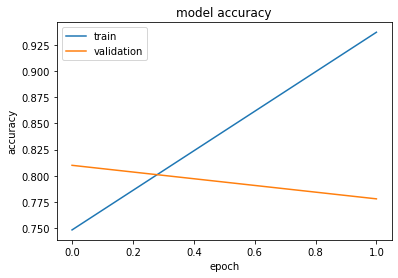

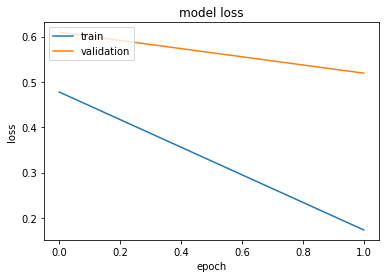

In [29]:
plt.plot(history2.history['binary_accuracy'])
plt.plot(history2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Modelo 2

In [30]:
model3 = Sequential()
model3.add(Embedding(maximo, 64, input_length=max_lenght))
model3.add(Conv1D(32, 2, activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool1D(3))
model3.add(Flatten())
model3.add(Dense(50, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 254, 64)           640000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 253, 32)           4128      
_________________________________________________________________
batch_normalization_4 (Batch (None, 253, 32)           128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 84, 32)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2688)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                134450    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [31]:
model3.compile(optimizer='RMSprop',
              loss='binary_crossentropy', metrics=['binary_accuracy'])

In [32]:
history3 = model3.fit(train_texts[0:50000], trainL[0:50000], 
                    batch_size=128, epochs=2, 
                    validation_data=(val_texts[0:1000], validationL[0:1000]),
                    callbacks=callbacks_list)

Train on 50000 samples, validate on 1000 samples
Epoch 1/2
50000/50000 [==============================] - 51s 1ms/step - loss: 0.3875 - binary_accuracy: 0.8132 - val_loss: 0.4339 - val_binary_accuracy: 0.8840

Epoch 00001: val_binary_accuracy improved from 0.81000 to 0.88400, saving model to Checkpoint3.hdf5
Epoch 2/2
50000/50000 [==============================] - 73s 1ms/step - loss: 0.2032 - binary_accuracy: 0.9225 - val_loss: 0.3704 - val_binary_accuracy: 0.8490

Epoch 00002: val_binary_accuracy did not improve from 0.88400


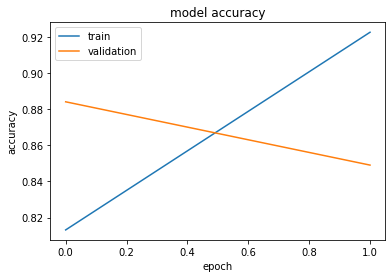

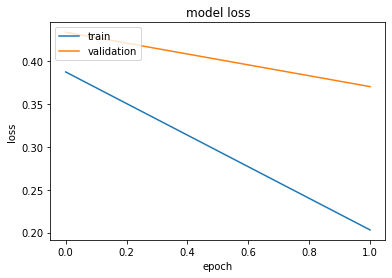

In [33]:
plt.plot(history3.history['binary_accuracy'])
plt.plot(history3.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Modelo 3

In [34]:
model4 = Sequential()
model4.add(Embedding(maximo, 128, input_length=max_lenght))
model4.add(Conv1D(64, 2, activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPool1D(3))
model4.add(Conv1D(64, 5, activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPool1D(3))
model4.add(Conv1D(64, 5, activation='relu'))
model4.add(Flatten())
model4.add(Dense(100, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 254, 128)          1280000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 253, 64)           16448     
_________________________________________________________________
batch_normalization_5 (Batch (None, 253, 64)           256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 80, 64)            20544     
_________________________________________________________________
batch_normalization_6 (Batch (None, 80, 64)            256       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 26, 64)           

In [35]:
model4.compile(optimizer='RMSprop',
              loss='binary_crossentropy', metrics=['binary_accuracy'])

In [36]:
history4 = model4.fit(train_texts[0:50000], trainL[0:50000], 
                    batch_size=128, epochs=2, 
                    validation_data=(val_texts[0:1000], validationL[0:1000]),
                    callbacks=callbacks_list)

Train on 50000 samples, validate on 1000 samples
Epoch 1/2
50000/50000 [==============================] - 194s 4ms/step - loss: 0.3960 - binary_accuracy: 0.8148 - val_loss: 0.4429 - val_binary_accuracy: 0.7650

Epoch 00001: val_binary_accuracy did not improve from 0.88400
Epoch 2/2
50000/50000 [==============================] - 202s 4ms/step - loss: 0.2030 - binary_accuracy: 0.9214 - val_loss: 0.2726 - val_binary_accuracy: 0.8910

Epoch 00002: val_binary_accuracy improved from 0.88400 to 0.89100, saving model to Checkpoint3.hdf5


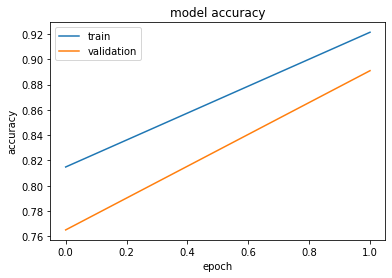

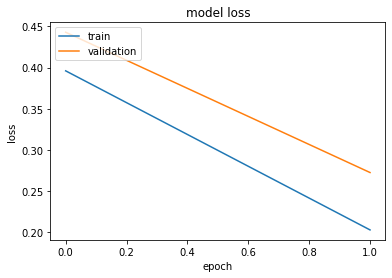

In [37]:
plt.plot(history4.history['binary_accuracy'])
plt.plot(history4.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Modelo 4

In [42]:
model5 = Sequential()
model5.add(Embedding(maximo, 128, input_length=max_lenght))
model5.add(Conv1D(64, 2, activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPool1D(3))
model5.add(Conv1D(64, 5, activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPool1D(3))
model5.add(Conv1D(64, 5, activation='relu'))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))
model5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 254, 128)          1280000   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 253, 64)           16448     
_________________________________________________________________
batch_normalization_9 (Batch (None, 253, 64)           256       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 80, 64)            20544     
_________________________________________________________________
batch_normalization_10 (Batc (None, 80, 64)            256       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 26, 64)           

In [43]:
model5.compile(optimizer='RMSprop',
              loss='binary_crossentropy', metrics=['binary_accuracy'])

In [44]:
history5 = model5.fit(train_texts[0:50000], trainL[0:50000], 
                    batch_size=128, epochs=2, 
                    validation_data=(val_texts[0:1000], validationL[0:1000]),
                    callbacks=callbacks_list)

Train on 50000 samples, validate on 1000 samples
Epoch 1/2
50000/50000 [==============================] - 169s 3ms/step - loss: 0.3907 - binary_accuracy: 0.8125 - val_loss: 0.5367 - val_binary_accuracy: 0.6770

Epoch 00001: val_binary_accuracy did not improve from 0.89100
Epoch 2/2
50000/50000 [==============================] - 192s 4ms/step - loss: 0.1974 - binary_accuracy: 0.9233 - val_loss: 0.3899 - val_binary_accuracy: 0.8600

Epoch 00002: val_binary_accuracy did not improve from 0.89100


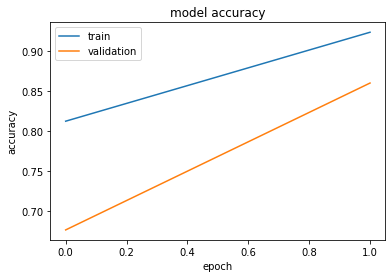

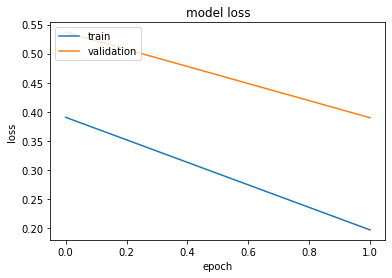

In [45]:
plt.plot(history5.history['binary_accuracy'])
plt.plot(history5.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Luego de probar algunas arquitecturas de redes neuronales recurrentes puede verse que la última que tiene una capa de embedding, 3 convolucionales, 2 maxpool y 1 densa antes de la salida tiene un buen comportamiento tanto para datos de entrenamiento como validación. Por lo cual se escogerá esta modelo para entrenar la red neuronal con el dataset completo de train y evaluar con el de validación

### Entrenamiento del Modelo Elegido

In [22]:
model = Sequential()
model.add(Embedding(maximo, 128, input_length=max_lenght))
model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 254, 128)          1280000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 253, 64)           16448     
_________________________________________________________________
batch_normalization_3 (Batch (None, 253, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 80, 64)            20544     
_________________________________________________________________
batch_normalization_4 (Batch (None, 80, 64)            256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 26, 64)           

In [25]:
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy', metrics=['binary_accuracy'])

In [26]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


filepath="Checkpoint3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


# checkpoint to stop training if model didn't improve valid loss for 3 epochs
callback_early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [28]:
history = model.fit(train_texts, trainL, 
                    batch_size=128, epochs=2, 
                    validation_data=(val_texts, validationL),
                    callbacks=callbacks_list)

Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 11954s 4ms/step - loss: 0.1802 - binary_accuracy: 0.9312 - val_loss: 0.1607 - val_binary_accuracy: 0.9400


C:\Users\Elda Calderon\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with binary_val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/2
3240000/3240000 [==============================] - 14064s 4ms/step - loss: 0.1624 - binary_accuracy: 0.9396 - val_loss: 0.1564 - val_binary_accuracy: 0.9423


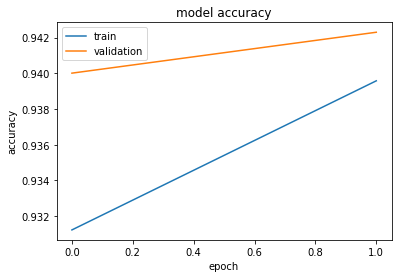

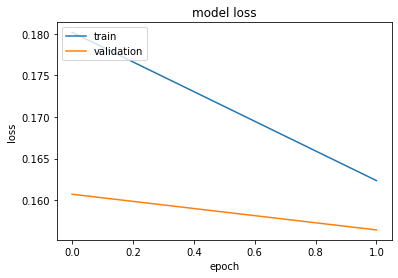

In [30]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Con este modelo puede verse que se logró un accuracy alrededor del 93%.

## Metricas del Modelo

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

In [33]:
# Accuracy Validation
model.evaluate(val_texts, validationL)

360000/360000 [==============================] - 412s 1ms/step


[0.15642823199455938, 0.9422944188117981]

In [34]:
# Accuracy Test
model.evaluate(test_texts, testL)

400000/400000 [==============================] - 475s 1ms/step


[0.15745685988917946, 0.9417750239372253]

In [44]:
# Prediccion Test
predict1 = model.predict_classes(test_texts)

In [39]:
# Prediccion Validation
predict = model.predict_classes(val_texts)

In [45]:
# Accuracy
acT = accuracy_score(testL, predict1)
acV = accuracy_score(validationL, predict)

print('Accuracy validation dataset:', acV)
print('Accuracy test dataset:', acT)

Accuracy validation dataset: 0.9422944444444444
Accuracy test dataset: 0.941775


In [47]:
# Precision
precT = precision_score(testL, predict1, average = 'macro')
precV = precision_score(validationL, predict, average = 'macro')

print('Precision validation dataset:', precV)
print('Precision test dataset:', precT)

Precision validation dataset: 0.9423406043870086
Precision test dataset: 0.9418365213172282


In [48]:
# Recall
recT = recall_score(testL, predict1, average = 'macro')
recV = recall_score(validationL, predict, average = 'macro')

print('Recall validation dataset:', recV)
print('Recall test dataset:', recT)

Recall validation dataset: 0.942305979776952
Recall test dataset: 0.941775


In [49]:
# F1-Score
f1T = f1_score(testL, predict1, average = 'macro')
f1V = f1_score(validationL, predict, average = 'macro')

print('F1-Score validation dataset:', f1V)
print('F1-Score test dataset:', f1T)

F1-Score validation dataset: 0.9422937397851081
F1-Score test dataset: 0.9417729731171942


In [50]:
# Confusion Matrix Test Dataset
confusion_matrix(testL, predict1)

array([[187175,  12825],
       [ 10465, 189535]], dtype=int64)

In [53]:
# Confusion Matrix Validation Dataset
confusion_matrix(validationL, predict)

array([[168984,  11395],
       [  9379, 170242]], dtype=int64)

## Checkpoints

Anteriormente en los modelos se habia aplicado un checkpoint y earlystopping como callbacks en la parte del entrenamiento

## Cargando el Checkpoint

In [47]:
model4.load_weights("Checkpoint3.hdf5")

In [48]:
model4.evaluate(val_texts[0:1000], validationL[0:1000])

1000/1000 [==============================] - 1s 1ms/step


[0.27262506091594696, 0.890999972820282]

# Conclusiones

Para la red neuronal del tipo recurrente se eligió trabajar con un problema de análisis de sentimientos acerca de reviews de Amazon. Las etiquetas de cada review pueden ser del tipo positivo o negativo, por lo que es un problema del tipo binario.

Algo importante a hacer en la parte inicial de procesamiento de datos es cambiar las etiquetas, ya que en el dataset por default las mismas estaban establecidas como 1 y 2, pero al trabajar con un modelo binario es necesario que las mismas sean 0 y 1 para que el modelo entrene adecuadamente. Por lo que las etiquetas 2 se cambiaron por cero, pero la interpretabilidad sigue siendo la misma.

El dataset con el que se contaba es considerablemente grande, el dataset de entrenamiento cuenta con mas de 3 millones de observaciones, por lo que se decidió hacer el entrenamiento únicamente con la arquitectura de red recurrente elegida ya que se contaba con suficientes datos.

Se probó con diferentes arquitecturas de red y como parte de la experimentación se entrenaron en una porción del dataset por cuestión del tiempo de entrenamiento. Luego se eligió el modelo que brindó mejores resultados en el Accuracy en el dataset de validación. 

La arquitectura final elegida esta estructura de la siguiente forma: capa de embedding, 3 convolucionales, 2 maxpool y 1 densa con activación Relu antes de la salida. La capa de salida dado el tipo binario de problema tiene activación sigmoid.
Como optimizador se eligió RMSprop, durante la experimentación se observó que Adam brindó buenos resultados también pero se decidió experimetnar con este optimizador.

El entrenamiento para este problema resultó costoso en cuanto al tiempo, ya que cada epoch tomó alrededor de 3 horas. Aquí se puede observar la importancia de los checkpoints, dado que si algo resulta mal durante el entrenamiento se puede utilizar esta herramienta para arrancar el entrenamiento desde un punto oportuno y no desde cero.

Como se ha mencionado en las fases anteriores del proyecto, es altamente recomendable colocar checkpoints e incluso early stopping para detener el entrenamiento si no hay una mejora en la métrica de interés.


En la parte de métricas el modelo resultó bastante bueno, para el dataset de validación y de test se obtuvo un accuracy de 94%. Otras métricas como f1-score, precision y recall también resultaron alrededor de 94% tanto para el dataset de validación como de test.

Por lo tanto se puede esperar que el modelo sea bastante bueno para según una review predecir que tipo es: positiva o negativa.